In [1]:
# Let's do our imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import pandas as pd
import os
import warnings
import urllib.request
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, validation_curve, cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from glob import glob
%matplotlib inline

In [5]:
train = pd.read_csv('../oscartraindata.csv', index_col=0)

print(train.shape)
train.head()

(485, 18)


,Year,Won?,Acting Noms,Acting Wins,Writing Noms,Writing Wins,Directing Noms,Directing Wins,Cinematography Noms,Cinematography Wins,Editing Noms,Editing Wins,Production Design Noms,Production Design Wins,Sound Noms,Sound Wins,Total Nominations,Total Wins
0,2010,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,4,1
1,2010,0,3,2,1,0,1,0,0,0,1,0,0,0,0,0,6,2
2,2010,0,0,0,1,0,0,0,1,1,0,0,1,0,3,2,6,3
3,2010,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0
4,2010,1,3,1,1,1,1,1,1,0,1,0,2,0,2,0,11,3


In [6]:
target = 'Won?'

xtrain = train.drop(columns=target)

ytrain = train[target]

In [7]:
# Now let's get a baseline. Let's say that we think that everyone will Lose (majority class)
ypred = np.full_like(ytrain, fill_value=0)

print(classification_report(ytrain, ypred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       402
           1       0.00      0.00      0.00        83

    accuracy                           0.83       485
   macro avg       0.41      0.50      0.45       485
weighted avg       0.69      0.83      0.75       485



C:\Users\Raul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
# Seeing how imbalanced the observations are, we'll use ROC AUC as our metric
Baseline = roc_auc_score(ytrain, ypred)    

print('Baseline ROC AUC score:', Baseline)

Baseline ROC AUC score: 0.5


In [9]:
# Now we can try to beat our baseline score
# Let's give the RandomForestClassifier a shot
# Note: We don't need pipeline anymore, our entire dataframe is integers
clf = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

k=5
groups = train['Year']
scores = cross_validate(clf,
                        xtrain,
                        ytrain,
                        cv=k,
                        scoring='roc_auc',
                        groups=groups,
                        return_estimator=True)

print(f'ROC AUC Score for {k} folds', scores['test_score'])

ROC AUC Score for 5 folds [0.92374728 0.96804648 0.95661765 0.87929687 0.73398438]


Directing Wins            0.251753
Total Wins                0.145389
Year                      0.129102
Total Nominations         0.112949
Writing Wins              0.056138
Acting Noms               0.048301
Directing Noms            0.042216
Editing Noms              0.038103
Production Design Noms    0.028656
Sound Noms                0.027620
Writing Noms              0.026740
Cinematography Noms       0.024954
Acting Wins               0.023519
Production Design Wins    0.016353
Sound Wins                0.010208
Editing Wins              0.009088
Cinematography Wins       0.008912
dtype: float64


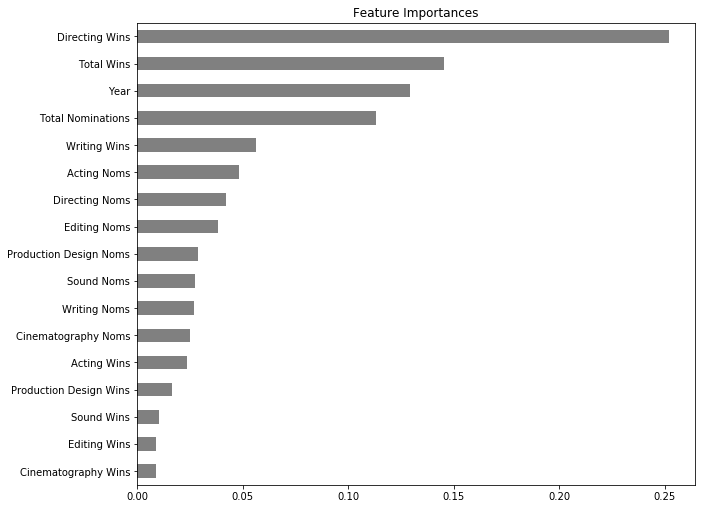

In [10]:
# Let's take a look at the feature importances
estimator = scores['estimator'][0]

importances = pd.Series(estimator.feature_importances_, xtrain.columns)

n = len(xtrain.columns)
plt.figure(figsize=(10,n/2))
plt.title('Feature Importances')
importances.sort_values().plot.barh(color='grey');
print(importances.sort_values(ascending=False))

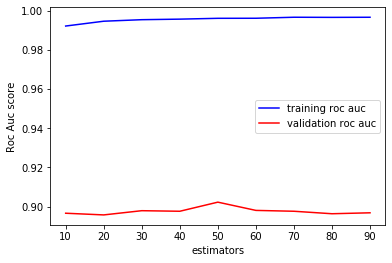

In [11]:
# Now let's take a look at the validation curve, with a range of n_estimators
clf = RandomForestClassifier(max_depth=7, random_state=42, n_jobs=-1)

k=5
groups = train['Year']
depth = range(10, 100, 10)

train_scores, val_scores= validation_curve(
    clf, xtrain, ytrain,
    param_name='n_estimators',
    param_range=depth,
    scoring='roc_auc',
    cv=k,
    groups=groups)

plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training roc auc')
plt.plot(depth, np.mean(val_scores, axis=1), color='red', label='validation roc auc')
plt.xlabel('estimators')
plt.ylabel('Roc Auc score')
plt.legend();

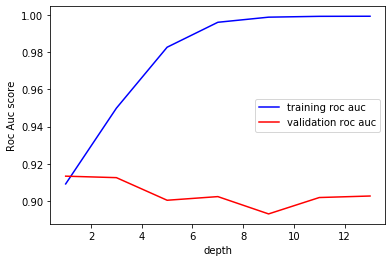

In [12]:
# Now with a range of max_depth values
clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)

k=5
groups = train['Year']
depth = range(1, 15, 2)

train_scores, val_scores= validation_curve(
    clf, xtrain, ytrain,
    param_name='max_depth',
    param_range=depth,
    scoring='roc_auc',
    cv=k,
    groups=groups)

plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training roc auc')
plt.plot(depth, np.mean(val_scores, axis=1), color='red', label='validation roc auc')
plt.xlabel('depth')
plt.ylabel('Roc Auc score')
plt.legend();

In [13]:
# The eyyeball test gives us some options to make chages to our classifier
clf = RandomForestClassifier(max_depth=3, n_estimators=50, random_state=42, n_jobs=-1)

k=5
groups = train['Year']
scores = cross_validate(clf,
                        xtrain,
                        ytrain,
                        cv=k,
                        scoring='roc_auc',
                        groups=groups,
                        return_estimator=True)

print(f'ROC AUC Score for {k} folds', scores['test_score'])

ROC AUC Score for 5 folds [0.96586783 0.96514161 0.96691176 0.9265625  0.73789063]


In [19]:
# Very little improvement. Let's use RandomizedSearchCV

from scipy.stats import randint, uniform

clf = RandomForestClassifier(random_state=42)


param_distributions={
    'n_estimators': randint(30, 500), 
    'max_features': uniform(), 
    'min_samples_leaf':  [1, 10, 100],    
    'max_depth': randint(1, 12)
}

k=3
groups = train['Year']

search = RandomizedSearchCV(
    clf,
    param_distributions=param_distributions,
    n_iter=5,
    cv=k,
    scoring='roc_auc',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(xtrain, ytrain, groups=groups)

print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    1.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    2.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.3s finished
C:\Users\Raul\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyperparameters {'max_depth': 2, 'max_features': 0.24601845647340748, 'min_samples_leaf': 10, 'n_estimators': 251}
Cross-validation Accuracy 0.9166206278377381


In [16]:
# Wow, that's a Great Score. Let's take a look at the hyperparameter values
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.152589,0.007237,0.032249,0.011866,1,0.451688,1,129,"{'max_depth': 1, 'max_features': 0.45168829142...",0.970283,0.960288,0.829740,0.920290,0.063961,1,0.883107,0.884566,0.968883,0.912185,0.040096
4,0.504982,0.019552,0.052522,0.003295,7,0.370702,10,403,"{'max_depth': 7, 'max_features': 0.37070243949...",0.969883,0.963486,0.816750,0.916912,0.070655,2,0.953019,0.956275,0.979211,0.962835,0.011656
2,0.084107,0.016395,0.008648,0.002348,4,0.218095,1,57,"{'max_depth': 4, 'max_features': 0.21809455702...",0.964286,0.961620,0.818961,0.915154,0.067817,3,0.959871,0.955733,0.989406,0.968336,0.014994
3,0.072806,0.016267,0.006982,0.000816,5,0.340172,10,60,"{'max_depth': 5, 'max_features': 0.34017218590...",0.966418,0.960821,0.809287,0.912387,0.072714,4,0.950237,0.955393,0.978545,0.961392,0.012310
1,0.629646,0.021578,0.070146,0.001695,7,0.718043,10,457,"{'max_depth': 7, 'max_features': 0.71804314194...",0.956823,0.959488,0.804726,0.907223,0.072261,5,0.965502,0.957972,0.984009,0.969161,0.010940


In [20]:
# I want to push the envelope. I'm going to give XGBClassifier a try also

clf = XGBClassifier(random_state=42, base_score=0.5)


param_distributions={
    'n_estimators': randint(30, 500), 
#     'max_features': uniform(), 
    'min_child_weight':  [1, 10, 100],    
    'max_depth': randint(1, 12)
}

k=3
groups = train['Year']

search = RandomizedSearchCV(
    clf,
    param_distributions=param_distributions,
    n_iter=5,
    cv=k,
    scoring='roc_auc',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(xtrain, ytrain, groups=groups)

print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1506s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.8s remaining:    0.3s


Best hyperparameters {'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 31}
Cross-validation Accuracy 0.8938329340044987


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished
C:\Users\Raul\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# Nope, not an improvement in this case